# Netflix Titles Data Analysis

This project focuses on the Netflix Titles dataset, which contains detailed information about thousands of movies and TV shows available on the platform. The dataset includes attributes such as title, type, director, cast, country of origin, release year, rating, duration, genres, and descriptions. By applying exploratory data analysis (EDA) and machine learning techniques, we aim to:

-Explore the distribution of content across years, countries, and genres.

-Identify patterns and clusters in Netflix’s catalog.

-Build predictive models to classify and estimate attributes (e.g., Movie vs TV Show, duration).

-Develop a recommendation system to suggest similar titles based on content features.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("netflix_titles.csv")

# Quick look
print(df.head())
print(df.info())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

# 1: Exploratory Data Analysis

In [11]:
# Missing values
print(df.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
cluster            0
dtype: int64


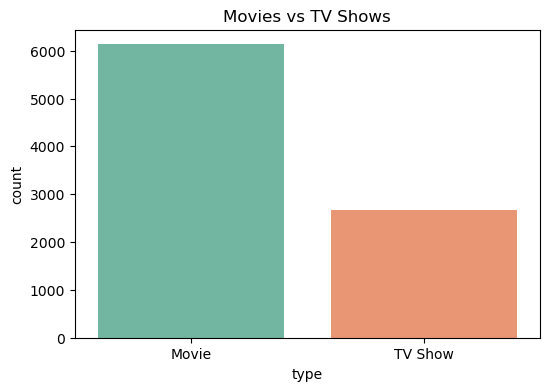

In [12]:
# Movies vs TV Shows
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="type", palette="Set2")
plt.title("Movies vs TV Shows")
plt.show()

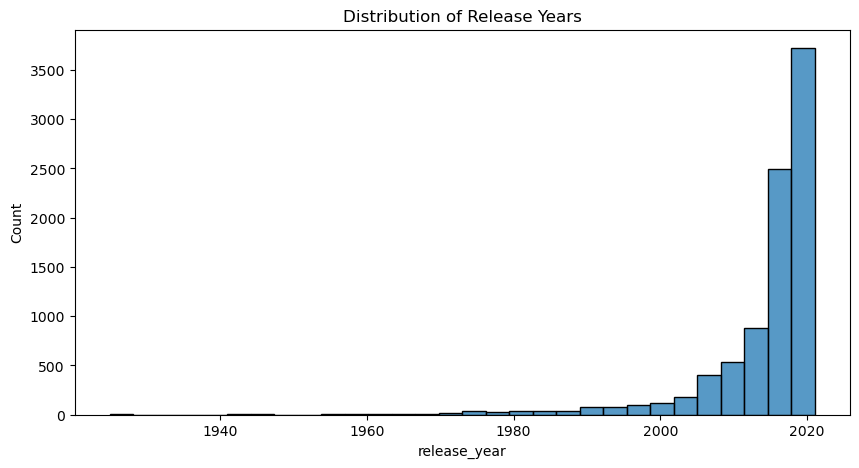

In [13]:
# Release year distribution
plt.figure(figsize=(10,5))
sns.histplot(df["release_year"], bins=30, kde=False)
plt.title("Distribution of Release Years")
plt.show()

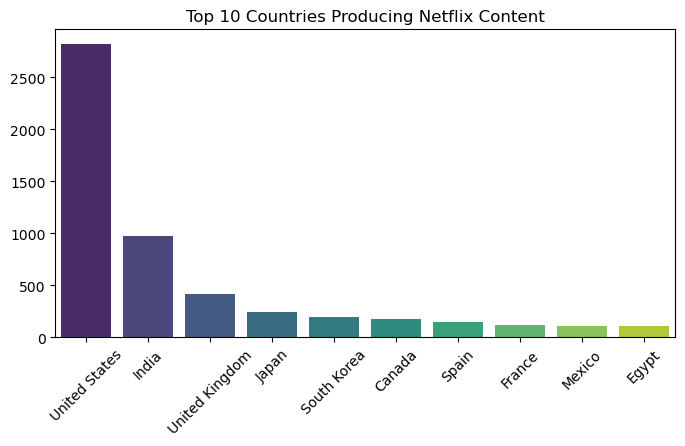

In [14]:
# Top 10 countries
top_countries = df["country"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title("Top 10 Countries Producing Netflix Content")
plt.xticks(rotation=45)
plt.show()

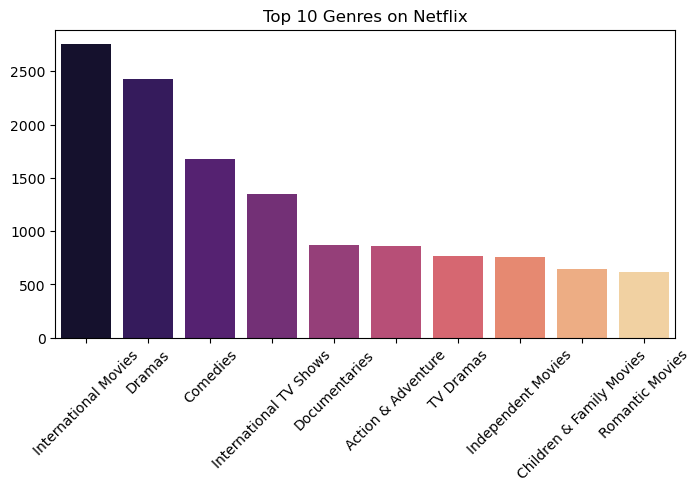

In [15]:
# Top genres
genres = df["listed_in"].str.split(",").explode().str.strip()
top_genres = genres.value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_genres.index, y=top_genres.values, palette="magma")
plt.title("Top 10 Genres on Netflix")
plt.xticks(rotation=45)
plt.show()

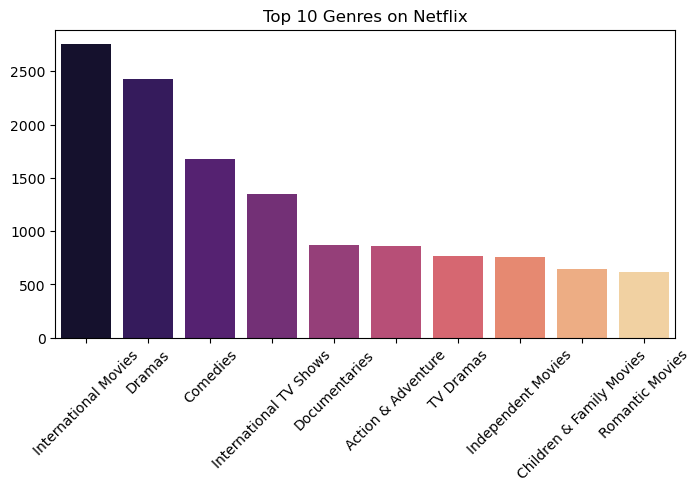

In [16]:
# Top genres
genres = df["listed_in"].str.split(",").explode().str.strip() 
top_genres = genres.value_counts().head(10) 
plt.figure(figsize=(8,4)) 
sns.barplot(x=top_genres.index, y=top_genres.values, palette="magma") 
plt.title("Top 10 Genres on Netflix") 
plt.xticks(rotation=45) 
plt.show()

# 2: Classification Model (RandomForestClassifier)

Accuracy: 0.996594778660613
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1214
           1       0.99      1.00      0.99       548

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762



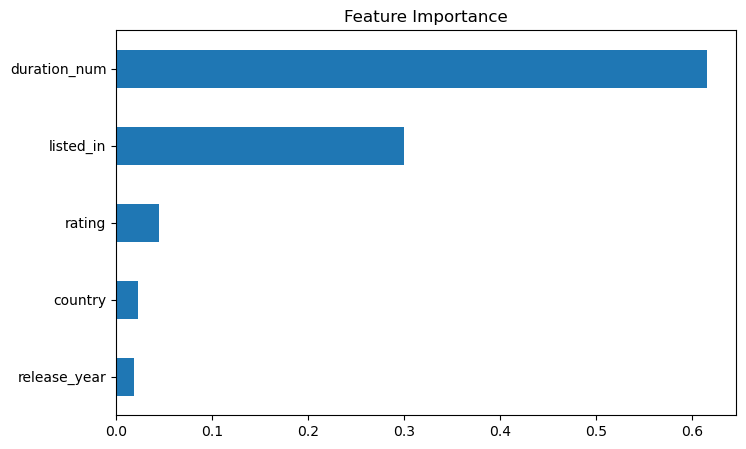

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Feature engineering
df_ml = df[["type", "release_year", "rating", "duration", "country", "listed_in"]].copy()

# Handle missing values
df_ml.fillna("Unknown", inplace=True)

# Simplify duration (convert to numeric minutes or seasons)
def parse_duration(x):
    if "Season" in x:
        return int(x.split()[0]) * 60  # approximate: 1 season ~ 60 minutes
    elif "min" in x:
        return int(x.split()[0])
    else:
        return 0

df_ml["duration_num"] = df_ml["duration"].apply(parse_duration)

# Encode categorical features
le_type = LabelEncoder()
df_ml["type"] = le_type.fit_transform(df_ml["type"])  # Movie=1, TV Show=0

for col in ["rating", "country", "listed_in"]:
    df_ml[col] = LabelEncoder().fit_transform(df_ml[col])

# Features and target
X = df_ml.drop(columns=["type", "duration"])
y = df_ml["type"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance")
plt.show()


# 3. Clustering Models (KMeans)

Goal: Group similar titles together based on genre, country, and other metadata.
Model: K‑Means or Hierarchical Clustering.
Use Case: Discover clusters of content (e.g., “family movies from India,” “crime dramas from the US”).

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use genres (listed_in) for clustering
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['listed_in'].fillna(""))

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

print(df[['title','listed_in','cluster']].head(10))


                              title  \
0              Dick Johnson Is Dead   
1                     Blood & Water   
2                         Ganglands   
3             Jailbirds New Orleans   
4                      Kota Factory   
5                     Midnight Mass   
6  My Little Pony: A New Generation   
7                           Sankofa   
8     The Great British Baking Show   
9                      The Starling   

                                           listed_in  cluster  
0                                      Documentaries        4  
1    International TV Shows, TV Dramas, TV Mysteries        3  
2  Crime TV Shows, International TV Shows, TV Act...        3  
3                             Docuseries, Reality TV        3  
4  International TV Shows, Romantic TV Shows, TV ...        3  
5                 TV Dramas, TV Horror, TV Mysteries        3  
6                           Children & Family Movies        2  
7   Dramas, Independent Movies, International Movies      

# 4: Recommendation System (Content-based)

Goal: Suggest similar titles to a given show/movie.
Model: Content‑based filtering using TF‑IDF + cosine similarity.
Use Case: Build a mini Netflix recommender.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF on descriptions
tfidf_desc = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_desc.fit_transform(df['description'].fillna(""))

# Cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Recommendation function
def recommend(title, cosine_sim=cosine_sim, df=df):
    # Check if title exists
    if title not in df['title'].values:
        return f"'{title}' not found in dataset."
    
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]  # skip itself
    recs = [df.iloc[i[0]]['title'] for i in sim_scores]
    return recs

# Example usage
print("Recommendations for 'Breaking Bad':", recommend("Breaking Bad"))


Recommendations for 'Breaking Bad': ['The Book of Sun', 'Alice Junior', 'Iron Ladies', 'Dismissed', 'Alexa & Katie']


# 5: Regression Models

Goal: Predict numeric values like duration or release year trends.
Model: Linear Regression, Gradient Boosting.
Use Case: Estimate duration based on genre/country, or forecast catalog growth.

In [19]:
from sklearn.linear_model import LinearRegression

# Features and target
X_reg = df_ml[['release_year','rating','country','listed_in']]
y_reg = df_ml['duration_num']

# Train regression model
reg = LinearRegression()
reg.fit(X_reg, y_reg)

# Predict using DataFrame to avoid warnings
sample = X_reg.iloc[[0]]   # double brackets keep it as DataFrame
prediction = reg.predict(sample)

print("Sample prediction for duration:", prediction[0])


Sample prediction for duration: 100.65889616443633
